In [47]:
from multiprocessing.pool import ThreadPool
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import numpy as np
import cv2

from sklearn.preprocessing import OneHotEncoder

from cascid.datasets.isic.database import get_df, get_train_test_images_raw
from cascid.datasets.isic.images import get_raw_image
from cascid.datasets.isic.fetcher import fetch_from_isic, save_metadata, download_image
from cascid.configs.isic_cnf import IMAGES_DIR
from cascid.image import apply_preprocessing

In [25]:
image_metadata = get_df()

image_metadata['is_cancer'] = image_metadata['diagnostic'].apply(lambda x: 1 if x in ['melanoma', 'basal cell carcinoma', 'squamous cell carcinoma'] else 0)

image_metadata

,isic_id,sex,diagnostic,age_approx,image_url,img_id,is_cancer
0,ISIC_1162337,male,MEL,45,https://content.isic-archive.com/a82fc918-76c7...,ISIC_1162337.jpg,0
1,ISIC_3909039,male,MEL,50,https://content.isic-archive.com/62d65089-0855...,ISIC_3909039.jpg,0
2,ISIC_6695831,female,MEL,65,https://content.isic-archive.com/a213f3c1-95e1...,ISIC_6695831.jpg,0
3,ISIC_2141237,female,MEL,85,https://content.isic-archive.com/7d9c8155-ab69...,ISIC_2141237.jpg,0
4,ISIC_8252406,male,MEL,85,https://content.isic-archive.com/f7205ec8-20c7...,ISIC_8252406.jpg,0
...,...,...,...,...,...,...,...
12067,ISIC_0064985,male,SCC,60,https://content.isic-archive.com/a62e48a3-e6c9...,ISIC_0064985.jpg,0
12068,ISIC_0064977,male,SCC,80,https://content.isic-archive.com/7db06c7e-7236...,ISIC_0064977.jpg,0
12069,ISIC_0064878,female,SCC,60,https://content.isic-archive.com/9bc8ec2e-12e1...,ISIC_0064878.jpg,0
12070,ISIC_0064760,female,SCC,70,https://content.isic-archive.com/9dec418e-59d5...,ISIC_0064760.jpg,0


In [26]:
def rotateImage(image, angle, center):
    row,col, *c = image.shape # Get image shape, discarding any color channels available
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0) # Make a rotation matrix using
    new_image = cv2.warpAffine(image, rot_mat, (col,row))
    return new_image

# Feature Extraction for 1 Image

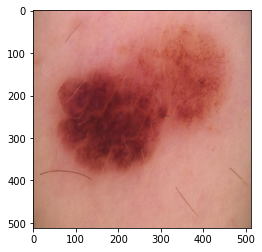

In [27]:
im = get_raw_image(image_metadata['img_id'].iloc[27], (512,512))

plt.imshow(im)

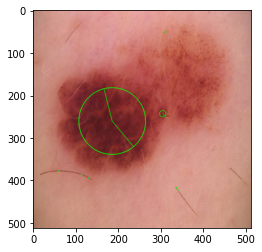

In [28]:
# Initiate ORB detector
orb = cv2.SIFT_create()
# find the keypoints with ORB
kp = orb.detect(im,None)
# compute the descriptors with ORB
kp, des = orb.compute(im, kp)
# draw
img2 = cv2.drawKeypoints(im, kp[:10], None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2)
plt.show();

In [29]:
kp[0].pt, kp[0].angle

((60.138938903808594, 377.624267578125), 90.07150268554688)

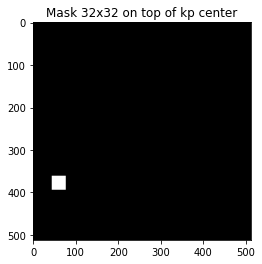

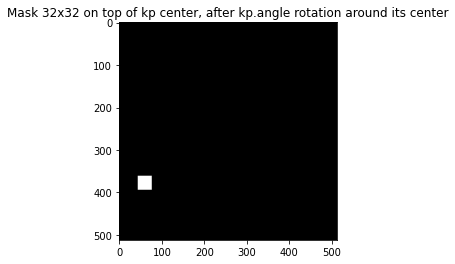

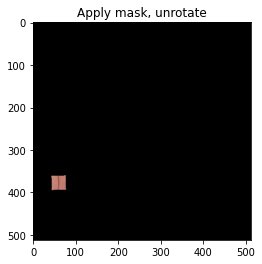

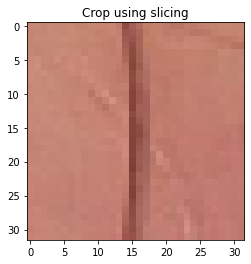

(36, 1024)


In [30]:
width = 32
plot_example = True
M = list()
for i in range(len(kp)):
    x = int(kp[i].pt[0]) # int conversion
    y = int(kp[i].pt[1]) # int conversion
    angle = kp[i].angle # angle in deg

    # Check for boundary
    if x<width//2 or x > (im.shape[1] - width//2) or y<width//2 or y > (im.shape[0] - width//2):
        continue

    mask = np.zeros_like(im) # black mask 
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # grayscale
    mask = cv2.rectangle(mask, (x-width//2, y+width//2), (x+width//2, y-width//2), 255, -1) # draw square
    mask_rot = rotateImage(mask, angle, (x,y)) # rotate square by angle
    roi = cv2.bitwise_and(im, im, mask=mask_rot) # Select mask region
    roi = rotateImage(roi, -angle, (x,y)) # unrotate
    roi_32 = roi[ y-width//2 : y+width//2 , x-width//2 : x+width//2 ] # crop
    if plot_example:
        plt.imshow(mask, cmap='gray')
        plt.title('Mask 32x32 on top of kp center')
        plt.show()
        plt.imshow(mask_rot, cmap='gray')
        plt.title('Mask 32x32 on top of kp center, after kp.angle rotation around its center')
        plt.show()
        plt.imshow(roi)
        plt.title('Apply mask, unrotate')
        plt.show()
        plt.imshow(roi_32)
        plt.title('Crop using slicing')
        plt.show()
        plot_example = False # Only show first
    roi_32 = cv2.cvtColor(roi_32, cv2.COLOR_RGB2LAB) # Convert to CIE-LAB
    roi_32 = roi_32[:,:,0] # Keep only L
    M.append(roi_32.flatten())
M = np.array(M)
print(M.shape)

In [31]:
u, s, vh = np.linalg.svd(M, full_matrices=False)

print(u.shape)
print(s.shape)
print(vh.shape)

(36, 36)
(36,)
(36, 1024)


In [32]:
for e in range(len(s)):
    vh[e] = s[e]*vh[e]

In [33]:
result = np.zeros(len(vh[0]))

for e in vh:
    result += e

result

array([-993.06943277, -979.02159586, -954.33487627, ..., -896.247714  ,
       -907.78384562, -922.03511169])

In [34]:
result_dict = { f"result_{i}" : result[i] for i in range(0, len(result) ) }

result_serie = pd.Series(result_dict)

result_serie[:10]

result_0    -993.069433
result_1    -979.021596
result_2    -954.334876
result_3    -996.034875
result_4    -999.487679
result_5   -1011.835254
result_6   -1008.493665
result_7    -965.981788
result_8    -964.861173
result_9    -976.606575
dtype: float64

In [35]:
print(image_metadata.iloc[10].img_id)

image_metadata.loc[image_metadata.index == 10, result_serie.index] = result_serie.values

image_metadata.loc[image_metadata.index == 10]

ISIC_4584265.jpg


,isic_id,sex,diagnostic,age_approx,image_url,img_id,is_cancer,result_0,result_1,result_2,...,result_1014,result_1015,result_1016,result_1017,result_1018,result_1019,result_1020,result_1021,result_1022,result_1023
10,ISIC_4584265,female,MEL,50,https://content.isic-archive.com/707ffddd-e7a2...,ISIC_4584265.jpg,0,-993.069433,-979.021596,-954.334876,...,-919.622561,-922.73802,-927.436732,-937.082974,-925.425725,-927.913965,-926.10544,-896.247714,-907.783846,-922.035112


# Model Classification

In [36]:
def extract_sift_features(img, width: int = 32):
    # Initiate detector
    orb = cv2.SIFT_create()
    # find the keypoints with ORB
    kp = orb.detect(im,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(im, kp)
    # draw
    # img2 = cv2.drawKeypoints(im, kp[:10], None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(img2)
    # plt.show();
    M = list()
    for i in range(len(kp)):
        x = int(kp[i].pt[0]) # int conversion
        y = int(kp[i].pt[1]) # int conversion
        angle = kp[i].angle # angle in deg
        
        # Check for boundary
        if x<width//2 or x > (im.shape[1] - width//2) or y<width//2 or y > (im.shape[0] - width//2):
            continue
        
        mask = np.zeros_like(im) # black mask 
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # grayscale
        mask = cv2.rectangle(mask, (x-width//2, y+width//2), (x+width//2, y-width//2), 255, -1) # draw square
        mask_rot = rotateImage(mask, angle, (x,y)) # rotate square by angle
        roi = cv2.bitwise_and(im, im, mask=mask_rot) # Select mask region
        roi = rotateImage(roi, -angle, (x,y)) # unrotate
        roi_32 = roi[ y-width//2 : y+width//2 , x-width//2 : x+width//2 ] # crop
        roi_32 = cv2.cvtColor(roi_32, cv2.COLOR_RGB2LAB) # Convert to CIE-LAB
        roi_32 = roi_32[:,:,0] # Keep only L
        M.append(roi_32.flatten())
    M = np.array(M)
    u, s, vh = np.linalg.svd(M, full_matrices=False)
    for e in range(len(s)):
        vh[e] = s[e]*vh[e]
    result = np.zeros(len(vh[0]))
    for e in vh:
        result += e
    return result

In [37]:
im.shape, extract_sift_features(im)

((512, 512, 3),
 array([-993.06943277, -979.02159586, -954.33487627, ..., -896.247714  ,
        -907.78384562, -922.03511169]))

In [80]:
try:
    with open(IMAGES_DIR / 'sift_cache.pickle', 'rb') as f:
        _dic = pk.load(f)
        x_train = _dic["x_train"]
        x_test  = _dic["x_test"] 
        y_train = _dic["y_train"]
        y_test  = _dic["y_test"] 
except (FileNotFoundError, KeyError):
    x_train, x_test, y_train, y_test = get_train_test_images_raw()
    print("Extracting SIFT features from all images, this can take up to 30min, please wait.")
    with ThreadPool(8) as TPool:
        x_train = np.array(TPool.map(extract_sift_features, x_train))
        x_test = np.array(TPool.map(extract_sift_features, x_test))
    with open(IMAGES_DIR / 'sift_cache.pickle', 'wb') as f:
        pk.dump(
            {
                "x_train" : x_train, 
                "x_test" : x_test, 
                "y_train" : y_train, 
                "y_test" : y_test
            },
            f
        )

OHE = OneHotEncoder(sparse=False)
y_train=np.array(list(map(lambda x: "Cancer" if x in ['BCC', 'MEL', 'SCC'] else "Not", y_train))).reshape(-1,1)
y_test=np.array(list(map(lambda x: "Cancer" if x in ['BCC', 'MEL', 'SCC'] else "Not", y_test))).reshape(-1,1)
OHE.fit(y_train)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [73]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=sorted(classes), yticklabels=sorted(classes),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig(title + '.png')
    return ax

def eval_model(model, x_test, y_test, title, *, classes=None):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    if classes:
        classes_list = classes
    else:
        classes_list = list(set(y_test))
        
    plot_confusion_matrix(y_test, y_pred, classes_list, normalize=True, title=title, save_to_file=True)

# Random Forest Classifier

In [81]:
x_train.shape, y_train.shape

((9657, 1024), (9657,))


Binary RFC
Model accuracy on train: 0.5508957233095164
Model accuracy on test: 0.5540372670807453


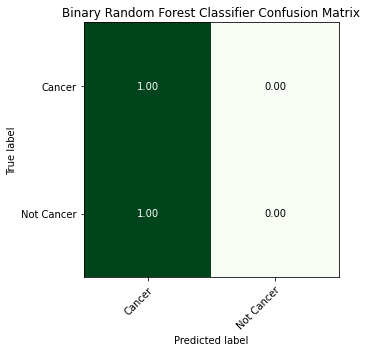

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

print("\nBinary RFC")
rfc_clf_bin = RandomForestClassifier(random_state=42, n_estimators=150)
rfc_clf_bin.fit(x_train, y_train)
eval_model(rfc_clf_bin, x_test, y_test, title="Binary Random Forest Classifier Confusion Matrix", classes=["Not Cancer", "Cancer"])
tr = cross_val_score(rfc_clf_bin, x_train, y_train, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf_bin, x_test, y_test, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

# Feature Importances

In [85]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_samples" : list(np.arange(0.4, 0.61, 0.1)),
    "n_estimators" : list(range(50, 501, 100)),
    "max_depth" : list(range(10,101,20)),
}
print(params)
grid = GridSearchCV(rfc_clf_bin,
                    params,
                    cv = 4,
                    scoring='accuracy',
                    return_train_score=True,
                    n_jobs=-1
)

grid.fit(x_train,y_train)

{'max_samples': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001], 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
